In [1]:
# python 3.7.3+
# contact@leonardofilipe.com

# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

# Implicit datetime converter
from pandas.plotting     import register_matplotlib_converters
register_matplotlib_converters()

#  Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC    = {}
    cookie  = ''
    crumb   = ''
    res     = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie  = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str  = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# Assets under consideration
tickers = ['%5EGSPTSE','%5EGSPC','%5ESTOXX','000001.SS']

# If yahoo data retrieval fails, try until it returns something
data = None
while data is None:
    try:
        data = getdata(tickers,'946685000','1555715000','1d')
    except:
         pass

ICP = pd.DataFrame({'SP500':    data['%5EGSPC']['Adj Close'],
                    'TSX':      data['%5EGSPTSE']['Adj Close'],
                    'STOXX600': data['%5ESTOXX']['Adj Close'][:-1], #[:-1] due to yahoo messing things up
                    'SSE':      data['000001.SS']['Adj Close'][:-1]}).fillna(method='ffill') #remove it later
ICP.tail()

,SP500,TSX,STOXX600,SSE
Date,,,,
2019-04-12,2907.409912,16480.500000,387.532013,3188.625977
2019-04-15,2905.580078,16515.500000,388.101990,3177.787109
2019-04-16,2907.060059,16502.199219,389.213013,3253.597900
2019-04-17,2900.449951,16544.199219,389.588989,3263.117920
2019-04-18,2905.030029,16612.800781,390.464996,3250.200928


In [2]:
BuyHold_SP     = ICP['SP500']    /float(ICP['SP500'][:1])   -1
BuyHold_TSX    = ICP['TSX']      /float(ICP['TSX'][:1])     -1
BuyHold_STOXX  = ICP['STOXX600'] /float(ICP['STOXX600'][:1])-1
BuyHold_SSE    = ICP['SSE']      /float(ICP['SSE'][:1])     -1
BuyHold_25Each = BuyHold_SP*(1/4) + BuyHold_TSX*(1/4) + BuyHold_STOXX*(1/4) + BuyHold_SSE*(1/4)

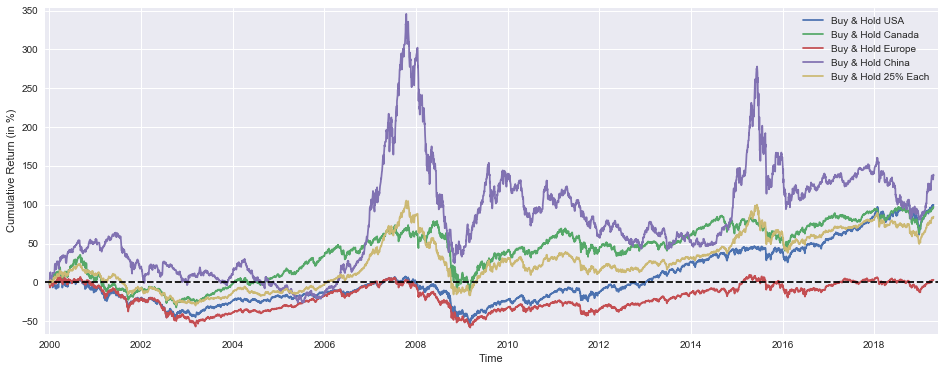

In [3]:
plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold USA')
plt.plot(BuyHold_TSX*100,    label='Buy & Hold Canada')
plt.plot(BuyHold_STOXX*100,  label='Buy & Hold Europe')
plt.plot(BuyHold_SSE*100,    label='Buy & Hold China')
plt.plot(BuyHold_25Each*100, label='Buy & Hold 25% Each')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [4]:
SP1Y     = ICP['SP500']    /ICP['SP500'].shift(252)   -1
TSX1Y    = ICP['TSX']      /ICP['TSX'].shift(252)     -1
STOXX1Y  = ICP['STOXX600'] /ICP['STOXX600'].shift(252)-1
SSE1Y    = ICP['SSE']      /ICP['SSE'].shift(252)     -1
Each251Y = SP1Y*(1/4) + TSX1Y*(1/4) +STOXX1Y*(1/4) + SSE1Y*(1/4)

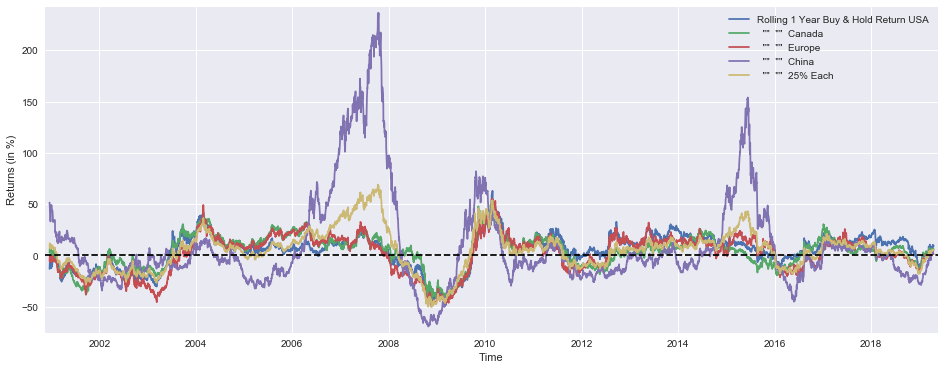

In [5]:
plt.figure(figsize=(16,6))
plt.plot(SP1Y*100,     label='Rolling 1 Year Buy & Hold Return USA')
plt.plot(TSX1Y*100,    label='  ""  ""  Canada')
plt.plot(STOXX1Y*100,  label='  ""  ""  Europe')
plt.plot(SSE1Y*100,    label='  ""  ""  China')
plt.plot(Each251Y*100, label='  ""  ""  25% Each')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [6]:
marr      = 0 #minimal acceptable rate of return (usually equal to the risk free rate)
SP1YS     = (SP1Y.mean()    -marr) /SP1Y.std()
TSX1YS    = (TSX1Y.mean()   -marr) /TSX1Y.std()
STOXX1YS  = (STOXX1Y.mean() -marr) /STOXX1Y.std()
SSE1YS    = (SSE1Y.mean()   -marr) /SSE1Y.std()
Each251YS = (Each251Y.mean()-marr) /Each251Y.std()

print('SP500 1 Year Buy & Hold Sharpe Ratio =',round(SP1YS,2))
print('TSX      "" "" =',round(TSX1YS   ,2))
print('STOXX600 "" "" =',round(STOXX1YS ,2))
print('SSE      "" "" =',round(SSE1YS   ,2))
print('25% Each "" "" =',round(Each251YS,2))

SP500 1 Year Buy & Hold Sharpe Ratio = 0.3
TSX      "" "" = 0.25
STOXX600 "" "" = 0.09
SSE      "" "" = 0.21
25% Each "" "" = 0.26


In [7]:
from scipy.optimize import minimize

def multi(x):
    a, b, c, d = x
    return a, b, c, d #the "optimal" weights we wish to discover

def maximize_sharpe(x): #objective function
    weights = (SP1Y*multi(x)[0] + TSX1Y*multi(x)[1]
               + STOXX1Y*multi(x)[2] + SSE1Y*multi(x)[3])
    return -(weights.mean()/weights.std())

def constraint(x): #since we're not using leverage nor short positions
    return 1 - (multi(x)[0]+multi(x)[1]+multi(x)[2]+multi(x)[3])

cons = ({'type':'ineq','fun':constraint})
bnds = ((0,1),(0,1),(0,1),(0,1))
initial_guess = (1, 0, 0, 0) #this algorithm (SLSQP) easly gets stuck on a local
# optimal solution, genetic algorithms usually yield better results
# so my inital guess is close to the global optimal solution

ms = minimize(maximize_sharpe, initial_guess, method='SLSQP',
              bounds=bnds, constraints=cons, options={'maxiter': 10000})

msBuyHoldAll = (BuyHold_SP*ms.x[0] + BuyHold_TSX*ms.x[1]
                + BuyHold_STOXX*ms.x[2] + BuyHold_SSE*ms.x[3])

msBuyHold1yAll = (SP1Y*ms.x[0] + TSX1Y*ms.x[1]
                   + STOXX1Y*ms.x[2] + SSE1Y*ms.x[3])

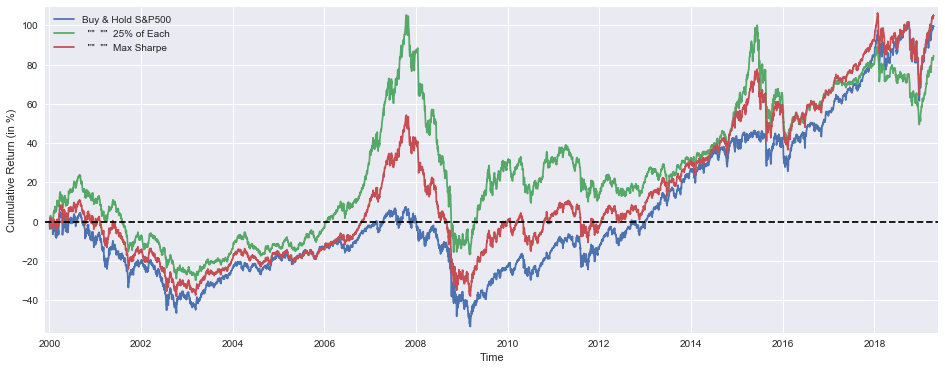

SP500 Weight = 85.71 %
TSX ""       = 0.0 %
STOXX600 ""  = 0.0 %
SSE ""       = 14.27 %

Sharpe = 0.326

Median yearly excess return over SP500 = -0.4 %
  ""  ""  ""  ""  over Equall Weights  = 2.3 %


In [8]:
plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold S&P500')
plt.plot(BuyHold_25Each*100, label='  ""  ""  25% of Each')
plt.plot(msBuyHoldAll*100,   label='  ""  ""  Max Sharpe')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('SP500 Weight =',round(ms.x[0]*100,2),'%')
print('TSX ""       =',round(ms.x[1]*100,2),'%')
print('STOXX600 ""  =',round(ms.x[2]*100,2),'%')
print('SSE ""       =',round(ms.x[3]*100,2),'%')
print()
print('Sharpe =',round(msBuyHold1yAll.mean()/msBuyHold1yAll.std(),3))
print()
print('Median yearly excess return over SP500 =',round((msBuyHold1yAll.median()-SP1Y.median())*100,1),'%')
print('  ""  ""  ""  ""  over Equall Weights  =',round((msBuyHold1yAll.median()-Each251Y.median())*100,1),'%')

In [9]:
def maximize_median_yearly_return(x): #different objective function
    weights = (SP1Y*multi(x)[0] + TSX1Y*multi(x)[1]
               + STOXX1Y*multi(x)[2] + SSE1Y*multi(x)[3])
    return -(float(weights.median()))

mm = minimize(maximize_median_yearly_return, initial_guess, method='SLSQP',
              bounds=bnds, constraints=cons, options={'maxiter': 10000})

mmBuyHoldAll = (BuyHold_SP*mm.x[0] + BuyHold_TSX*mm.x[1]
                + BuyHold_STOXX*mm.x[2] + BuyHold_SSE*mm.x[3])

mmBuyHold1yAll = (SP1Y*mm.x[0] + TSX1Y*mm.x[1]
                   + STOXX1Y*mm.x[2] + SSE1Y*mm.x[3])

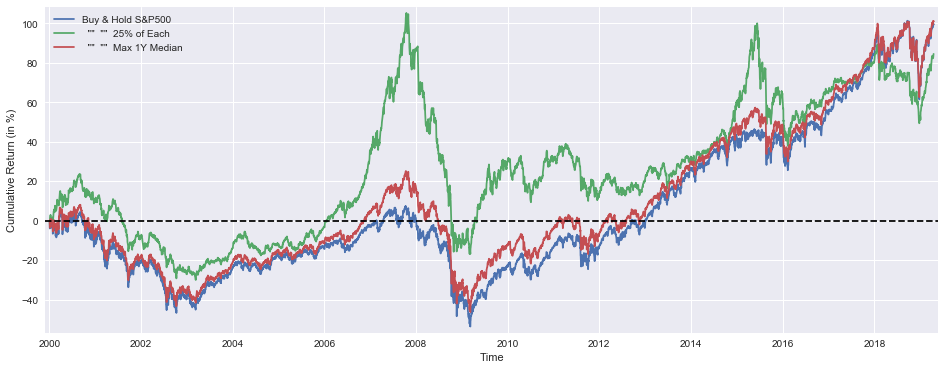

SP500 Weight = 89.83 %
TSX ""       = 5.75 %
STOXX600 ""  = 0.0 %
SSE ""       = 4.42 %

Sharpe = 0.314

Median yearly excess return over SP500 = 0.4 %
  ""  ""  ""  ""  over Equall Weights  = 3.1 %


In [10]:
plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold S&P500')
plt.plot(BuyHold_25Each*100, label='  ""  ""  25% of Each')
plt.plot(mmBuyHoldAll*100,   label='  ""  ""  Max 1Y Median')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('SP500 Weight =',round(mm.x[0]*100,2),'%')
print('TSX ""       =',round(mm.x[1]*100,2),'%')
print('STOXX600 ""  =',round(mm.x[2]*100,2),'%')
print('SSE ""       =',round(mm.x[3]*100,2),'%')
print()
print('Sharpe =',round(mmBuyHold1yAll.mean()/mmBuyHold1yAll.std(),3))
print()
print('Median yearly excess return over SP500 =',round((mmBuyHold1yAll.median()-SP1Y.median())*100,1),'%')
print('  ""  ""  ""  ""  over Equall Weights  =',round((mmBuyHold1yAll.median()-Each251Y.median())*100,1),'%')

In [11]:
YTD_SP     = ICP['SP500'][-252:]    /float(ICP['SP500'][-252])   -1
YTD_TSX    = ICP['TSX'][-252:]      /float(ICP['TSX'][-252])     -1
YTD_STOXX  = ICP['STOXX600'][-252:] /float(ICP['STOXX600'][-252])-1
YTD_SSE    = ICP['SSE'][-252:]      /float(ICP['SSE'][-252])     -1
YTD_25Each = YTD_SP*(1/4) + YTD_TSX*(1/4) + YTD_STOXX*(1/4) + YTD_SSE*(1/4)

YTD_max_sharpe = YTD_SP*ms.x[0] + YTD_TSX*ms.x[1] + YTD_STOXX*ms.x[2] + YTD_SSE*ms.x[3]
YTD_max_median = YTD_SP*mm.x[0] + YTD_TSX*mm.x[1] + YTD_STOXX*mm.x[2] + YTD_SSE*mm.x[3]

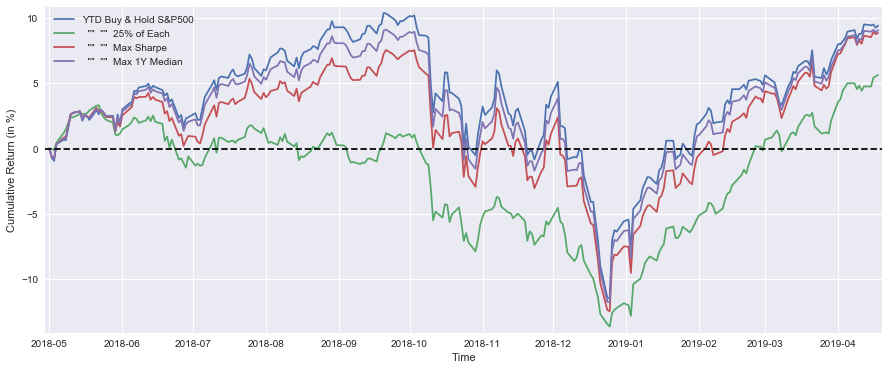

Buy & Hold S&P500 YTD Performance (at 19 April 2019) = 9.4 %
 "" "" 25% of Each   "" "" = 5.6 %
 "" "" Max Sharpe    "" "" = 8.9 %
 "" "" Max 1Y Median "" "" = 9.1 %


In [12]:
plt.figure(figsize=(15,6))
plt.plot(YTD_SP*100,         label='YTD Buy & Hold S&P500')
plt.plot(YTD_25Each*100,     label='  ""  ""  25% of Each')
plt.plot(YTD_max_sharpe*100, label='  ""  ""  Max Sharpe')
plt.plot(YTD_max_median*100, label='  ""  ""  Max 1Y Median')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Buy & Hold S&P500 YTD Performance (at 19 April 2019) =',round(float(YTD_SP[-1:]*100),1),'%')
print(' "" "" 25% of Each   "" "" =',round(float(YTD_25Each[-1:]*100),1),'%')
print(' "" "" Max Sharpe    "" "" =',round(float(YTD_max_sharpe[-1:]*100),1),'%')
print(' "" "" Max 1Y Median "" "" =',round(float(YTD_max_median[-1:]*100),1),'%')

In [13]:
ICP['SPRet']    = ICP['SP500'] /ICP['SP500'].shift(1)-1
ICP['SSERet']   = ICP['SSE']   /ICP['SSE'].shift(1)  -1

ICP['Strat'] = ICP['SPRet'] * 0.8 + ICP['SSERet'] * 0.2
ICP['Strat'][SP1Y.shift(1)  > -0.17] = ICP['SSERet']*0 + ICP['SPRet']*1
ICP['Strat'][SSE1Y.shift(1) > 0.29]  = ICP['SSERet']*1 + ICP['SPRet']*0

DynAssAll    = ICP['Strat'].cumsum()
DynAssAll1y  = ICP['Strat'].rolling(window=252).sum()
DynAssAllytd = ICP['Strat'][-251:].cumsum()

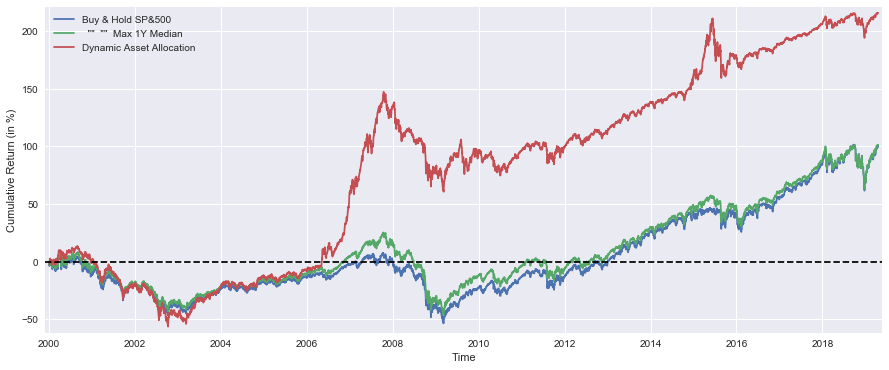

Median yearly excess return over SP500 = 2.5 %
  ""  ""  ""  ""  over Max 1Y Median   = 2.1 %


In [14]:
plt.figure(figsize=(15,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold SP&500')
plt.plot(mmBuyHoldAll*100,   label='  ""  ""  Max 1Y Median')
plt.plot(DynAssAll*100,      label='Dynamic Asset Allocation')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Median yearly excess return over SP500 =',round(float(DynAssAll1y.median()-SP1Y.median())*100,1),'%')
print('  ""  ""  ""  ""  over Max 1Y Median   =',round(float(DynAssAll1y.median()-mmBuyHold1yAll.median())*100,1),'%')

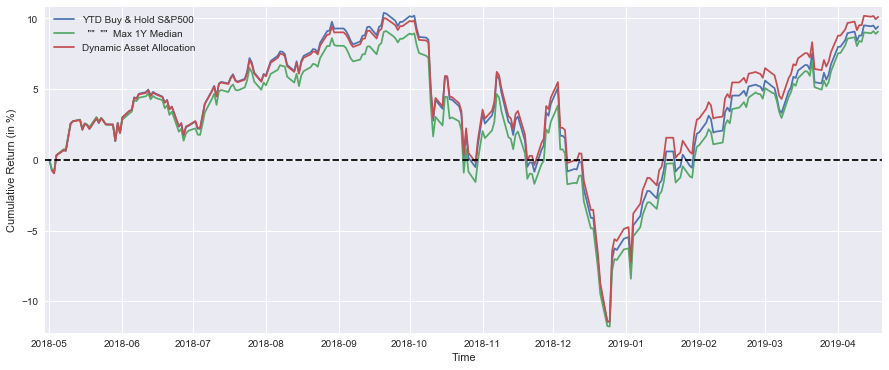

Buy & Hold S&P500 YTD Performance (at 19 April 2019) = 9.4 %
 "" "" Max 1Y Median "" ""  = 9.1 %
 Strategy YTD Performance   = 10.1 %


In [15]:
plt.figure(figsize=(15,6))
plt.plot(YTD_SP*100,         label='YTD Buy & Hold S&P500')
plt.plot(YTD_max_median*100, label='  ""  ""  Max 1Y Median')
plt.plot(DynAssAllytd*100,   label='Dynamic Asset Allocation')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Buy & Hold S&P500 YTD Performance (at 19 April 2019) =',round(float(YTD_SP[-1:]*100),1),'%')
print(' "" "" Max 1Y Median "" ""  =',round(float(YTD_max_median[-1:]*100),1),'%')
print(' Strategy YTD Performance   =',round(float(DynAssAllytd[-1:]*100),1),'%')